# Overview & Usage of the Tensorflow Quant Library 
## 1. Import all the good stuff & create shortcuts
Use the fixed local volatility model here

In [1]:
"""Local Volatility Model Duplicated & Fixed here."""

import functools
from typing import Any, Callable, List, Optional, Union

import tensorflow.compat.v2 as tf

from tf_quant_finance import black_scholes
from tf_quant_finance import datetime
from tf_quant_finance import math
from tf_quant_finance import types
from tf_quant_finance.experimental.pricing_platform.framework.market_data import volatility_surface
from tf_quant_finance.math import interpolation
from tf_quant_finance.math import piecewise
from tf_quant_finance.math import random
from tf_quant_finance.models import generic_ito_process

interpolation_2d = interpolation.interpolation_2d
cubic = interpolation.cubic
linear = interpolation.linear


def _dupire_local_volatility_prices(time, spot_price, initial_spot_price,
                                    implied_volatility_surface,
                                    discount_factor_fn, dividend_yield):
  """Constructs local volatility function using Dupire's formula.

  Args:
    time: A real `Tensor` of shape compatible with `spot_price` specifying the
      times at which local volatility function is computed.
    spot_price: A real `Tensor` specifying the underlying price at which local
      volatility function is computed.
    initial_spot_price: A real `Tensor` of shape compatible with `spot_price`
      specifying the underlying spot price at t=0.
    implied_volatility_surface: A Python callable which implements the
      interpolation of market implied volatilities. The callable should have the
      interface `implied_volatility_surface(strike, expiry_times)` which takes
      real `Tensor`s corresponding to option strikes and time to expiry and
      returns a real `Tensor` containing the corresponding market implied
      volatility. The shape of `strike` is `(n,dim)` where `dim` is the
      dimensionality of the local volatility process and `t` is a scalar tensor.
      The output from the callable is a `Tensor` of shape `(n,dim)` containing
      the interpolated implied volatilties.
    discount_factor_fn: A python callable accepting one real `Tensor` argument
      time t. It should return a `Tensor` specifying the discount factor to time
      t.
    dividend_yield: A real `Tensor` of shape compatible with `spot_price`
      specifying the (continuously compounded) dividend yield.

  Returns:
    A real `Tensor` of same shape as `spot_price` containing the local
    volatility computed at `(spot_price,time)` using Dupire's
    construction of local volatility.
  """
  dtype = time.dtype

  risk_free_rate_fn = _get_risk_free_rate_from_discount_factor(
      discount_factor_fn)
  risk_free_rate = tf.convert_to_tensor(risk_free_rate_fn(time), dtype=dtype)

  def _option_price(expiry_time, strike):
    discount_factors = tf.convert_to_tensor(
        discount_factor_fn(expiry_time), dtype=dtype)
    vols = implied_volatility_surface(strike=strike, expiry_times=expiry_time)
    c_k_t = black_scholes.option_price(
        volatilities=vols,
        strikes=strike,
        expiries=expiry_time,
        spots=initial_spot_price,
        dividend_rates=dividend_yield,
        discount_factors=discount_factors,
        dtype=dtype)
    return c_k_t

  dcdk_fn = lambda x: _option_price(time, x)
  dcdt_fn = lambda x: _option_price(x, spot_price)
  d2cdk2_fn = lambda x: math.fwd_gradient(dcdk_fn, x)

  # TODO(b/173568116): Replace gradients of call prices with imp vol gradients.
  numerator = (
      math.fwd_gradient(dcdt_fn, time) + (risk_free_rate - dividend_yield) *
      spot_price * math.fwd_gradient(dcdk_fn, spot_price) +
      dividend_yield * _option_price(time, spot_price))
  denominator = math.fwd_gradient(d2cdk2_fn, spot_price) * spot_price**2
  # we use relu for safety so that we do not take the square root of
  # negative real `Tensors`.
  local_volatility_squared = tf.nn.relu(
      2 * tf.math.divide_no_nan(numerator, denominator))
  return tf.math.sqrt(local_volatility_squared)

def _dupire_local_volatility_iv(time, spot_price, initial_spot_price,
                                implied_volatility_surface, discount_factor_fn,
                                dividend_yield):
  """Similar to _dupire_local_volatility_prices, but uses implied vols."""
  dtype = time.dtype

  risk_free_rate_fn = _get_risk_free_rate_from_discount_factor(
      discount_factor_fn)
  risk_free_rate = tf.convert_to_tensor(risk_free_rate_fn(time), dtype=dtype)

  def _implied_vol(expiry_time, strike):
    return implied_volatility_surface(strike=strike, expiry_times=expiry_time)

  theta = _implied_vol(time, spot_price)
  d1 = tf.math.divide_no_nan(
      (tf.math.log(initial_spot_price / spot_price) +
       (risk_free_rate - dividend_yield + 0.5 * theta**2) * time) / theta,
      tf.math.sqrt(time))

  spot_fn = lambda x: _implied_vol(time, x)
  time_fn = lambda t: _implied_vol(t, spot_price)
  dtheta_dt = lambda t: math.fwd_gradient(time_fn, t)
  dtheta_dspot = lambda x: math.fwd_gradient(spot_fn, x)
  d2theta_dspot2 = lambda x: math.fwd_gradient(dtheta_dspot, x)

  numerator = (
      theta**2 + 2 * time * theta * dtheta_dt(time) + 2 *
      (risk_free_rate - dividend_yield) * spot_price * time * theta *
      dtheta_dspot(spot_price))
  denominator = (
      (1 + spot_price * d1 * tf.math.sqrt(time) * dtheta_dspot(spot_price))**2 +
      spot_price**2 * time * theta *
      (d2theta_dspot2(spot_price) - d1 * tf.math.sqrt(time) * dtheta_dspot(spot_price)**2))
  local_volatility_squared = tf.nn.relu(
      tf.math.divide_no_nan(numerator, denominator))
  return tf.math.sqrt(local_volatility_squared)


def _dupire_local_volatility_iv_precomputed(
    initial_spot_price: types.RealTensor, implied_volatility_surface: Any,
    discount_factor_fn: Callable[..., types.RealTensor],
    dividend_yield: Callable[..., types.RealTensor],
    times_grid: types.RealTensor, spot_grid: types.RealTensor, dim: int,
    dtype: tf.DType) -> Callable[..., types.RealTensor]:
  """Constructs local volatility function using Dupire's formula.

  Returns a function similar to _dupire_local_volatility_iv using precomputed
  spline coefficients for IV.

  Args:
    initial_spot_price: A real `Tensor` specifying the underlying spot price at
      t=0.
    implied_volatility_surface: A Python callable which implements the
      interpolation of market implied volatilities. The callable should have the
      interface `implied_volatility_surface(strike, expiry_times)` which takes
      real `Tensor`s corresponding to option strikes and time to expiry and
      returns a real `Tensor` containing the corresponding market implied
      volatility. The shape of `strike` is `(n,dim)` where `dim` is the
      dimensionality of the local volatility process and `t` is a scalar tensor.
      The output from the callable is a `Tensor` of shape `(n,dim)` containing
      the interpolated implied volatilties.
    discount_factor_fn: A python callable accepting one real `Tensor` argument
      time t. It should return a `Tensor` specifying the discount factor to time
      t.
    dividend_yield: A real `Tensor` of shape compatible with `spot_price`
      specifying the (continuously compounded) dividend yield.
    times_grid: A `Tensor` of shape `[num_time_samples]`. The grid on which to
      do interpolation over time.
    spot_grid: A `Tensor` of shape `[num_spot_samples]`. The grid on which to do
      interpolation over spots.
    dim: An int. The model dimension.
    dtype: The default dtype to use when converting values to `Tensor`s.

  Returns:
    A python callable f(spot_price,time) returning a real `Tensor` of same shape
    as `spot_price` containing the local volatility computed at
    `(spot_price,time)` using Dupire's construction of local volatility.
  """
  times_grid = tf.convert_to_tensor(times_grid, dtype=dtype)
  spot_grid = tf.convert_to_tensor(spot_grid, dtype=dtype)

  # Add batch dim.
  times_grid = tf.expand_dims(times_grid, 0)
  spot_grid = tf.expand_dims(spot_grid, 0)

  # Pre-compute IV.
  def map_times(times):

    def wrap_implied_vol(time):
      spots = tf.transpose(spot_grid)
      # TODO(b/229480163): Batch this.
      return implied_volatility_surface(strike=spots, expiry_times=time)

    return tf.vectorized_map(wrap_implied_vol, tf.transpose(times))

  implied_vol_grid = map_times(times_grid)
  implied_vol_grid = tf.transpose(implied_vol_grid, [0, 2, 1])

  # Pre-compute gradients using spline for dTheta/dt.
  def map_times_grad(times):

    def wrap_implied_vol(time):
      spots = tf.transpose(spot_grid)
      # TODO(b/229480163): Batch this.
      return implied_volatility_surface(strike=spots, expiry_times=time)

    fn_grad = lambda time: math.fwd_gradient(wrap_implied_vol, time)
    return tf.vectorized_map(fn_grad, tf.transpose(times))

  grad_implied_vol_grid = map_times_grad(times_grid)
  grad_implied_vol_grid = tf.transpose(grad_implied_vol_grid, [0, 2, 1])

  # Set up grids for interpolation.
  times_grid = tf.squeeze(times_grid)
  spot_grid = tf.squeeze(spot_grid)
  spot_grid_2d = tf.broadcast_to(spot_grid,
                                 [times_grid.shape[0], dim, spot_grid.shape[0]])
  spline_info = cubic.build_spline(
      spot_grid_2d, implied_vol_grid, name='spline_spots', validate_args=True)

  jump_locations = tf.slice(times_grid, [1], [times_grid.shape[0] - 1])
  spline_coeffs_fn = piecewise.PiecewiseConstantFunc(jump_locations,
                                                     spline_info.spline_coeffs)
  spot_grid_2d_fn = piecewise.PiecewiseConstantFunc(
      jump_locations, spot_grid_2d, dtype=dtype)
  implied_vol_grid_fn = piecewise.PiecewiseConstantFunc(
      jump_locations, implied_vol_grid, dtype=dtype)
  spline_grad_info = cubic.build_spline(
      spot_grid_2d,
      grad_implied_vol_grid,
      name='spline_grad_spots',
      validate_args=True)

  grad_implied_vol_grid_fn = piecewise.PiecewiseConstantFunc(
      jump_locations, grad_implied_vol_grid, dtype=dtype)
  spline_grad_coeffs_fn = piecewise.PiecewiseConstantFunc(
      jump_locations, spline_grad_info.spline_coeffs)

  def local_variance(time, spot_price):
    risk_free_rate_fn = _get_risk_free_rate_from_discount_factor(
        discount_factor_fn)
    risk_free_rate = tf.convert_to_tensor(risk_free_rate_fn(time), dtype=dtype)

    # Setup to compute IV and gradients.
    spot_grid_2d = tf.squeeze(spot_grid_2d_fn([time]), 0)
    implied_vol_grid = tf.squeeze(implied_vol_grid_fn([time]), 0)
    spline_coeffs = tf.squeeze(spline_coeffs_fn([time]), 0)
    spline = math.interpolation.cubic.SplineParameters(spot_grid_2d,
                                                       implied_vol_grid,
                                                       spline_coeffs)

    def theta_fn(spot):
      return tf.transpose(
          math.interpolation.cubic.interpolate(
              tf.transpose(spot), spline, dtype=dtype))

    def grad_spots_fn(spot):
      return math.fwd_gradient(
          theta_fn, spot, unconnected_gradients=tf.UnconnectedGradients.ZERO)

    theta = theta_fn(spot_price)

    # Compute gradient of `theta` wrt `time`
    grad_implied_vol_grid = tf.squeeze(grad_implied_vol_grid_fn([time]), 0)
    spline_grad_coeffs = tf.squeeze(spline_grad_coeffs_fn([time]), 0)

    spline_grad = math.interpolation.cubic.SplineParameters(
        spot_grid_2d, grad_implied_vol_grid, spline_grad_coeffs)

    grad_times = tf.transpose(
        math.interpolation.cubic.interpolate(
            tf.transpose(spot_price), spline_grad, dtype=dtype))

    # Then set up the rest of Dupire as usual.
    d1 = tf.math.divide_no_nan(
        (tf.math.log(tf.math.divide_no_nan(initial_spot_price, spot_price)) +
         (risk_free_rate - dividend_yield + 0.5 * theta**2) * time) / theta,
        tf.math.sqrt(time))

    spots_t = spot_price
    # Gradient of `theta` wrt `spots`
    grad_spots = grad_spots_fn(spots_t)
    # Second gradient of `theta` wrt `spots`
    grad_grad_spots = math.fwd_gradient(
        grad_spots_fn,
        spots_t,
        unconnected_gradients=tf.UnconnectedGradients.ZERO)

    # Dupire formula
    local_var = (
        (theta**2 + 2 * time * theta * grad_times + 2 *
         (risk_free_rate - dividend_yield) * spots_t * time * theta *
         grad_spots) /
        ((1 + spots_t * d1 * time * grad_spots)**2 + spots_t**2 * time * theta *
         (grad_grad_spots - d1 * time * grad_spots**2)))
    local_var = tf.nn.relu(local_var)
    return tf.math.sqrt(local_var)

  return local_variance


class LocalVolatilityModel(generic_ito_process.GenericItoProcess):
  r"""Local volatility model for smile modeling.

  Local volatility (LV) model specifies that the dynamics of an asset is
  governed by the following stochastic differential equation:

  ```None
    dS(t) / S(t) =  mu(t, S(t)) dt + sigma(t, S(t)) * dW(t)
  ```
  where `mu(t, S(t))` is the drift and `sigma(t, S(t))` is the instantaneous
  volatility. The local volatility function `sigma(t, S(t))` is state dependent
  and is computed by calibrating against a given implied volatility surface
  `sigma_iv(T, K)` using the Dupire's formula [1]:

  ```
  sigma(T,K)^2 = 2 * (dC(T,K)/dT + (r - q)K dC(T,K)/dK + qC(T,K)) /
                     (K^2 d2C(T,K)/dK2)
  ```
  where the derivatives above are the partial derivatives. The LV model provides
  a flexible framework to model any (arbitrage free) volatility surface.

  #### Example: Simulation of local volatility process.
  """

  def __init__(
      self,
      dim: int,
      risk_free_rate: Optional[Union[types.RealTensor,
                                     Optional[types.RealTensor]]] = None,
      dividend_yield: Optional[Union[types.RealTensor,
                                     Optional[types.RealTensor]]] = None,
      local_volatility_fn: Optional[Callable[..., types.RealTensor]] = None,
      corr_matrix: Optional[types.RealTensor] = None,
      times_grid: Optional[types.RealTensor] = None,
      spot_grid: Optional[types.RealTensor] = None,
      precompute_iv: Optional[bool] = False,
      dtype: Optional[tf.DType] = None,
      name: Optional[str] = None):
    """Initializes the Local volatility model.

    If `precompute_iv` is True and `times_grid` and `spot_grid` are supplied, an
    interpolated version that pre-computes spline coefficients is used.

    Args:
      dim: A Python scalar which corresponds to the number of underlying assets
        comprising the model.
      risk_free_rate: One of the following: (a) An optional real `Tensor` of
        shape compatible with `[dim]` specifying the (continuously compounded)
        risk free interest rate. (b) A python callable accepting one real
        `Tensor` argument time t returning a `Tensor` of shape compatible with
        `[dim]`. If the underlying is an FX rate, then use this input to specify
        the domestic interest rate.
        Default value: `None` in which case the input is set to Zero.
      dividend_yield: A real `Tensor` of shape compatible with `spot_price`
        specifying the (continuously compounded) dividend yield. If the
        underlying is an FX rate, then use this input to specify the foreign
        interest rate.
        Default value: `None` in which case the input is set to Zero.
      local_volatility_fn: A Python callable which returns instantaneous
        volatility as a function of state and time. The function must accept a
        scalar `Tensor` corresponding to time 't' and a real `Tensor` of shape
        `[num_samples, dim]` corresponding to the underlying price (S) as inputs
        and return a real `Tensor` of shape `[num_samples, dim]` containing the
        local volatility computed at (S,t).
      corr_matrix: A `Tensor` of shape `[dim, dim]` and the same `dtype` as
        `risk_free_rate`. Corresponds to the instantaneous correlation between
        the underlying assets.
      times_grid: A `Tensor` of shape `[num_time_samples]`. The grid on which to
        do interpolation over time. Must be jointly specified with `spot_grid`.
        Default value: `None`.
      spot_grid: A `Tensor` of shape `[num_spot_samples]`. The grid on which to
        do interpolation over spots. Must be jointly specified with
        `times_grid`.
        Default value: `None`.
      precompute_iv: A bool. Whether or not to precompute implied volatility
        spline coefficients when using Dupire. If True, then `times_grid` and
        `spot_grid` must be supplied.
        Default value: False.
      dtype: The default dtype to use when converting values to `Tensor`s.
        Default value: `None` which means that default dtypes inferred by
          TensorFlow are used.
      name: Python string. The name to give to the ops created by this class.
        Default value: `None` which maps to the default name
          `local_volatility_model`.

    Raises:
      ValueError: If `precompute_iv` is True, but grids are not supplied.
    """
    self._name = name or 'local_volatility_model'
    self._times_grid = None
    self._local_volatility_fn = local_volatility_fn
    # Mark that we're using the interpolated version.
    self._precompute_iv = precompute_iv
    if precompute_iv:
      if (times_grid is None or spot_grid is None):
        raise ValueError(
            'When `precompute_iv` is True, both `times_grid` and `spot_grid` '
            'must be supplied')
      self._times_grid = times_grid

    with tf.name_scope(self._name):
      self._dtype = dtype
      risk_free_rate = [0.0] if risk_free_rate is None else risk_free_rate
      dividend_yield = [0.0] if dividend_yield is None else dividend_yield

      self._domestic_rate = _convert_to_tensor_fn(risk_free_rate, dtype,
                                                  'risk_free_rate')
      self._foreign_rate = _convert_to_tensor_fn(dividend_yield, dtype,
                                                 'dividend_yield')

      corr_matrix = corr_matrix or tf.eye(dim, dim, dtype=self._dtype)
      self._rho = tf.convert_to_tensor(
          corr_matrix, dtype=self._dtype, name='rho')
      self._sqrt_rho = tf.linalg.cholesky(self._rho)

      # TODO(b/173286140): Simulate using X(t)=log(S(t))
      def _vol_fn(t, log_spot):
        """Volatility function of LV model."""
        lv = self._local_volatility_fn(t, tf.math.exp(log_spot))
        lv = tf.expand_dims(lv, axis=-1)
        return lv * self._sqrt_rho

      # Drift function
      def _drift_fn(t, log_spot):
        """Drift function of LV model."""
        domestic_rate = self._domestic_rate(t)
        foreign_rate = self._foreign_rate(t)
        lv = self._local_volatility_fn(t, tf.math.exp(log_spot))
        return domestic_rate - foreign_rate - lv * lv / 2

      super(LocalVolatilityModel, self).__init__(
          dim, _drift_fn, _vol_fn, dtype, name)

  def local_volatility_fn(self):
    """Local volatility function."""
    return self._local_volatility_fn

  def precompute_iv(self) -> bool:
    """Whether or not to precompute IV in Dupire's formula."""
    return self._precompute_iv

  def sample_paths(
      self,
      times: types.RealTensor,
      num_samples: Optional[int] = 1,
      initial_state: Optional[types.RealTensor] = None,
      random_type: Optional[random.RandomType] = None,
      seed: Optional[types.IntTensor] = None,
      swap_memory: Optional[bool] = True,
      time_step: Optional[types.RealTensor] = None,
      num_time_steps: Optional[types.IntTensor] = None,
      skip: Optional[types.IntTensor] = 0,
      precompute_normal_draws: Optional[bool] = True,
      times_grid: Optional[types.RealTensor] = None,
      normal_draws: Optional[types.RealTensor] = None,
      watch_params: Optional[List[types.RealTensor]] = None,
      validate_args: Optional[bool] = False,
      name: Optional[str] = None) -> types.RealTensor:  # pylint: disable=g-doc-args
    """Returns samples from the LV process.

    See GenericItoProcess.sample_paths. If `times_grid` is supplied to
    `__init__`, then `times_grid` cannot be supplied here.

    Raises:
      ValueError: If `precompute_iv` is True, but `time_step`, `num_time_steps`
        or `times_grid` are given.
    """
    name = name or (self._name + '_log_sample_path')
    with tf.name_scope(name):
      if initial_state is not None:
        initial_state = tf.math.log(
            tf.convert_to_tensor(initial_state, dtype_hint=tf.float64))
      if self.precompute_iv():
        if (time_step is not None or num_time_steps is not None or
            times_grid is not None):
          raise ValueError(
              '`time_step`, `num_time_steps`, or `times_grid` cannot be used'
              'with the interpolated LVM')
        times_grid = self._times_grid
      return tf.math.exp(
          super(LocalVolatilityModel, self).sample_paths(
              times=times,
              num_samples=num_samples,
              initial_state=initial_state,
              random_type=random_type,
              seed=seed,
              swap_memory=swap_memory,
              name=name,
              time_step=time_step,
              num_time_steps=num_time_steps,
              skip=skip,
              precompute_normal_draws=precompute_normal_draws,
              times_grid=times_grid,
              normal_draws=normal_draws,
              watch_params=watch_params,
              validate_args=validate_args))

  @classmethod
  def from_market_data(
      cls,
      dim: int,
      valuation_date: types.DateTensor,
      expiry_dates: types.DateTensor,
      strikes: types.RealTensor,
      implied_volatilities: types.RealTensor,
      spot: types.RealTensor,
      discount_factor_fn: Callable[..., types.RealTensor],
      dividend_yield: Optional[Callable[..., types.RealTensor]] = None,
      local_volatility_from_iv: Optional[bool] = True,
      times_grid: Optional[types.RealTensor] = None,
      spot_grid: Optional[types.RealTensor] = None,
      precompute_iv: Optional[bool] = False,
      dtype: Optional[tf.DType] = None,
      name: Optional[str] = None) -> generic_ito_process.GenericItoProcess:
    """Creates a `LocalVolatilityModel` from market data.

    Args:
      dim: A Python scalar which corresponds to the number of underlying assets
        comprising the model.
      valuation_date: A `DateTensor` specifying the valuation (or settlement)
        date for the market data.
      expiry_dates: A `DateTensor` of shape `(dim, num_expiries)` containing the
        expiry dates on which the implied volatilities are specified.
      strikes: A `Tensor` of real dtype and shape `(dim, num_expiries,
        num_strikes)`specifying the strike prices at which implied volatilities
        are specified.
      implied_volatilities: A `Tensor` of real dtype and shape `(dim,
        num_expiries, num_strikes)` specifying the implied volatilities.
      spot: A real `Tensor` of shape `(dim,)` specifying the underlying spot
        price on the valuation date.
      discount_factor_fn: A python callable accepting one real `Tensor` argument
        time t. It should return a `Tensor` specifying the discount factor to
        time t.
      dividend_yield: A real `Tensor` of shape compatible with `spot_price`
        specifying the (continuously compounded) dividend yield. If the
        underlying is an FX rate, then use this input to specify the foreign
        interest rate.
        Default value: `None` in which case the input is set to Zero.
      local_volatility_from_iv: A bool. If True, calculates the Dupire local
        volatility function from implied volatilities. Otherwise, it computes
        the local volatility using option prices.
        Default value: True.
      times_grid: A `Tensor` of shape `[num_time_samples]`. The grid on which to
        do interpolation over time. Must be jointly specified with `spot_grid`
        or `None`.
        Default value: `None`.
      spot_grid: A `Tensor` of shape `[num_spot_samples]`. The grid on which to
        do interpolation over spots. Must be jointly specified with `times_grid`
        or `None`.
        Default value: `None`.
      precompute_iv: A bool. Whether or not to precompute implied volatility
        spline coefficients when using Dupire's formula. This is done by
        precomputing values of implied volatility on the grid
        `times_grid x spot_grid`. The algorithm then steps through `times_grid`
        in `sample_paths`.
        Default value: False.
      dtype: The default dtype to use when converting values to `Tensor`s.
        Default value: `None` which means that default dtypes inferred by
          TensorFlow are used.
      name: Python string. The name to give to the ops created by this class.
        Default value: `None` which maps to the default name `from_market_data`.

    Returns:
      An instance of `LocalVolatilityModel` constructed using the input data.
    """
    name = name or 'from_market_data'
    if precompute_iv and (times_grid is None or spot_grid is None):
      raise ValueError(
          'When `precompute_iv` is True, both `times_grid` and `spot_grid` must'
          ' be supplied')
    with tf.name_scope(name):
      spot = tf.convert_to_tensor(spot, dtype=dtype)
      dtype = dtype or spot.dtype
      dividend_yield = [0.0] if dividend_yield is None else dividend_yield
      dividend_yield = tf.convert_to_tensor(dividend_yield, dtype=dtype)

      risk_free_rate_fn = _get_risk_free_rate_from_discount_factor(
          discount_factor_fn)

      valuation_date = datetime.convert_to_date_tensor(valuation_date)
      expiry_dates = datetime.convert_to_date_tensor(expiry_dates)
      expiry_times = (
          tf.cast(valuation_date.days_until(expiry_dates), dtype=dtype) / 365.0)
      strikes = tf.convert_to_tensor(strikes, dtype=dtype)
      implied_volatilities = tf.convert_to_tensor(
          implied_volatilities, dtype=dtype)

      def _log_forward_moneyness(times, strikes):
        # log_fwd_moneyness = log(strike/(spot*exp((r-d)*times)))
        risk_free_rate = tf.squeeze(risk_free_rate_fn(times))
        log_forward_moneyness = tf.math.log(
            tf.math.divide_no_nan(strikes, tf.reshape(
                spot, [dim, 1, 1]))) - tf.expand_dims(
                    (risk_free_rate - dividend_yield) * times, axis=-1)
        return log_forward_moneyness

      interpolator = interpolation_2d.Interpolation2D(
          expiry_times,
          _log_forward_moneyness(expiry_times, strikes),
          implied_volatilities,
          dtype=dtype)

      def _log_moneyness_2d_interpolator(times, strikes):
        risk_free_rate = risk_free_rate_fn(times)
        log_forward_moneyness = tf.math.log(
            strikes / spot) - (risk_free_rate - dividend_yield) * times
        moneyness_transposed = tf.transpose(log_forward_moneyness)

        times = tf.broadcast_to(times, moneyness_transposed.shape)
        return tf.transpose(
            interpolator.interpolate(times, moneyness_transposed))

      vs = volatility_surface.VolatilitySurface(
          valuation_date,
          expiry_dates,
          strikes,
          implied_volatilities,
          interpolator=_log_moneyness_2d_interpolator,
          dtype=dtype)

      if precompute_iv:
        local_volatility_fn = _dupire_local_volatility_iv_precomputed(
            initial_spot_price=spot,
            discount_factor_fn=discount_factor_fn,
            dividend_yield=dividend_yield,
            implied_volatility_surface=vs.volatility,
            times_grid=times_grid,
            spot_grid=spot_grid,
            dim=dim,
            dtype=dtype)
      else:
        local_volatility_fn = functools.partial(
            _dupire_local_volatility_iv
            if local_volatility_from_iv else _dupire_local_volatility_prices,
            initial_spot_price=spot,
            discount_factor_fn=discount_factor_fn,
            dividend_yield=dividend_yield,
            implied_volatility_surface=vs.volatility)

      return LocalVolatilityModel(
          dim,
          risk_free_rate=risk_free_rate_fn,
          dividend_yield=dividend_yield,
          local_volatility_fn=local_volatility_fn,
          times_grid=times_grid,
          spot_grid=spot_grid,
          precompute_iv=precompute_iv,
          dtype=dtype)

  @classmethod
  def from_volatility_surface(
      cls,
      dim: int,
      spot: types.RealTensor,
      implied_volatility_surface: Any,
      discount_factor_fn: Callable[..., types.RealTensor],
      dividend_yield: Optional[Callable[..., types.RealTensor]] = None,
      local_volatility_from_iv: Optional[bool] = True,
      times_grid: Optional[types.RealTensor] = None,
      spot_grid: Optional[types.RealTensor] = None,
      precompute_iv: Optional[bool] = False,
      dtype: Optional[tf.DType] = None,
      name: Optional[str] = None) -> generic_ito_process.GenericItoProcess:
    """Creates a `LocalVolatilityModel` from implied volatility data.

    Args:
      dim: A Python scalar which corresponds to the number of underlying assets
        comprising the model.
      spot: A real `Tensor` of shape `(dim,)` specifying the underlying spot
        price on the valuation date.
      implied_volatility_surface: Either an instance of
        `processed_market_data.VolatilitySurface` or a Python object containing
        the implied volatility market data. If the input is a Python object,
        then the object must implement a function `volatility(strike,
        expiry_times)` which takes real `Tensor`s corresponding to option
        strikes and time to expiry and returns a real `Tensor` containing the
        corresponding market implied volatility. The shape of `strike` is
        `(n,dim)` where `dim` is the dimensionality of the local volatility
        process and `t` is a scalar tensor. The output from the callable is a
        `Tensor` of shape `(n,dim)` containing the interpolated implied
        volatilties.
      discount_factor_fn: A python callable accepting one real `Tensor` argument
        time t. It should return a `Tensor` specifying the discount factor to
        time t.
      dividend_yield: A real `Tensor` of shape compatible with `spot_price`
        specifying the (continuously compounded) dividend yield. If the
        underlying is an FX rate, then use this input to specify the foreign
        interest rate.
        Default value: `None` in which case the input is set to Zero.
      local_volatility_from_iv: A bool. If True, calculates the Dupire local
        volatility function from implied volatilities. Otherwise, it computes
        the local volatility using option prices.
        Default value: True.
      times_grid: A `Tensor` of shape `[num_time_samples]`. The grid on which to
        do interpolation over time. Must be jointly specified with `spot_grid`
        or `None`.
        Default value: `None`.
      spot_grid: A `Tensor` of shape `[num_spot_samples]`. The grid on which to
        do interpolation over spots. Must be jointly specified with `times_grid`
        or `None`.
        Default value: `None`.
      precompute_iv: A bool. Whether or not to precompute implied volatility
        spline coefficients when using Dupire's formula. This is done by
        precomputing values of implied volatility on the grid
        `times_grid x spot_grid`. The algorithm then steps through `times_grid`
        in `sample_paths`.
        Default value: False.
      dtype: The default dtype to use when converting values to `Tensor`s.
        Default value: `None` which means that default dtypes inferred by
          TensorFlow are used.
      name: Python string. The name to give to the ops created by this class.
        Default value: `None` which maps to the default name
          `from_volatility_surface`.

    Returns:
      An instance of `LocalVolatilityModel` constructed using the input data.
    """
    name = name or 'from_volatility_surface'
    if precompute_iv and (times_grid is None or spot_grid is None):
      raise ValueError(
          'When `precompute_iv` is True, both `times_grid` and `spot_grid` must'
          ' be supplied')
    with tf.name_scope(name):
      dividend_yield = [0.0] if dividend_yield is None else dividend_yield
      dividend_yield = tf.convert_to_tensor(dividend_yield, dtype=dtype)

      risk_free_rate_fn = _get_risk_free_rate_from_discount_factor(
          discount_factor_fn)

      if precompute_iv:
        local_volatility_fn = _dupire_local_volatility_iv_precomputed(
            initial_spot_price=spot,
            discount_factor_fn=discount_factor_fn,
            dividend_yield=dividend_yield,
            implied_volatility_surface=implied_volatility_surface.volatility,
            times_grid=times_grid,
            spot_grid=spot_grid,
            dim=dim,
            dtype=dtype)
      else:
        local_volatility_fn = functools.partial(
            _dupire_local_volatility_iv
            if local_volatility_from_iv else _dupire_local_volatility_prices,
            initial_spot_price=spot,
            discount_factor_fn=discount_factor_fn,
            dividend_yield=dividend_yield,
            implied_volatility_surface=implied_volatility_surface.volatility)

      return LocalVolatilityModel(
          dim,
          risk_free_rate=risk_free_rate_fn,
          dividend_yield=dividend_yield,
          local_volatility_fn=local_volatility_fn,
          times_grid=times_grid,
          spot_grid=spot_grid,
          precompute_iv=precompute_iv,
          dtype=dtype)


def _convert_to_tensor_fn(x, dtype, name):
  if callable(x):
    return x
  else:
    return lambda t: tf.convert_to_tensor(x, dtype, name=name)


def _get_risk_free_rate_from_discount_factor(discount_factor_fn):
  """Returns r(t) given a discount factor function."""

  def risk_free_rate_fn(t):
    logdf = lambda x: -tf.math.log(discount_factor_fn(x))
    return math.fwd_gradient(
        logdf, t, unconnected_gradients=tf.UnconnectedGradients.ZERO)

  return risk_free_rate_fn


In [2]:
# Import all the libraries as required
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf

import tf_quant_finance as tff 
 
# Shortcut alias
pde = tff.math.pde
option_price = tff.black_scholes.option_price
implied_vol = tff.black_scholes.implied_vol


In [3]:
# RestClient -> BASTION Volsurface endpoint
"""
    This module implements the Local Client to the BASTION volsurface
"""

import time
import urllib.parse
from typing import Optional, Dict, Any

import hmac
import json
import requests

class RestClient:
    def __init__(self, api_url, api_key=None, api_secret=None, subaccount_name=None) -> None:
        self.API_URL = api_url
        self._api_key = api_key
        self._api_secret = api_secret
        self._subaccount_name = subaccount_name

    def _get(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('GET', path, params=params)

    def _post(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('POST', path, payload=params)

    def _delete(self, path: str, params: Optional[Dict[str, Any]] = None) -> Any:
        return self._request('DELETE', path, payload=params)

    def _request(self, method: str, endpoint: str, auth: bool = True, params={}, payload={}, api=None):
        for count in range(1,4):
            try:
                _payload = json.dumps(payload) if payload else ''
                _endpoint=f'{endpoint}?{urllib.parse.urlencode(params, safe="/")}' if params else _endpoint
                if not api:
                    api = self.API_URL

                url = f'{api}{_endpoint}'

                header = {}
                if method == 'GET':
                    response = requests.get(url, headers=header, timeout=3)
                elif method == 'POST':
                    response = requests.post(url, data=_payload, headers=header, timeout=3)
                elif method == 'DELETE':
                    response = requests.delete(url, data=_payload, headers=header, timeout=3)

                data = response.json()
                response.close()
                return data
            except ConnectionError as err:
                time.sleep(0.5*count)
            except Exception as err:
                time.sleep(0.5*count)

    def _generate_signature(self, timestamp: str, method: str, endpoint: str, data='') -> dict:
        message = f'{timestamp}{method}{endpoint}{data}'
        signature = hmac.new(self._api_secret.encode('utf-8'), message.encode('utf-8'), 'sha256').hexdigest()
        return signature

    def get_endpoint(self, endpoint, params={}):
        return self._get(endpoint, params)

    def post_endpoint(self, endpoint, params={}):
        return self._post(endpoint, params)

client = RestClient("https://defi-bot.bastioncb.com:1443/")


## 2. Get the Volsurface from BASTION

In [4]:
# 1. Feed Volatility surface using a processed_market_data.VolatilitySurface instance
import datetime
from tf_quant_finance.experimental.pricing_platform.framework.market_data.volatility_surface import VolatilitySurface

# Check spot reference 
#SPOT_REF = 22930

#YYYY-MM-DD
# Today -> Valuation date
TODAY = datetime.date(2022, 6, 15)
# Query volsurface from ~ 1-2 weeks from now since BASTION volsurface isn't fit properly:
DAY_REF = datetime.date(2022, 6, 29) 
MONTHS = 12 

all_maturities = [
  #datetime.date(2022, 6, 24),
  #datetime.date(2022, 7, 1),
  datetime.date(2022, 7, 29),
  datetime.date(2022, 8, 26),
  datetime.date(2022, 9, 30),
  datetime.date(2022, 12, 30),
  datetime.date(2023, 3, 23)

]

In [5]:
# Get Volsurface

# Construct tff native Datetensors
valuation_date = tff.datetime.dates_from_datetimes([TODAY])
dates = [DAY_REF + datetime.timedelta(days=i) for i in range(1, 30*MONTHS)]
#dates = all_maturities

# SET expiries as a (1 x Maturities) tensor 
expiries = tff.datetime.dates_from_datetimes(dates).reshape((1,-1))

# Construct the strike space
dk = 250
S = [10000 + dk*i for i in range(60000//dk)]

# Obtain IVs from volsurface
date_strings = ",".join([date.strftime('%d%b%y').upper() for date in dates])
strikes_strings = ",".join([str(strike) for strike in S])
params =  {"symbols": "BTC", "maturities": date_strings, "strikes": strikes_strings}

# dict: { 'iv': {maturity: {price: iv, ... }, ... }, 
#         'forward_price': {maturity: price, ...} }
response = client.get_endpoint('volsurface/forward_price', params)
# 2D dict, 1D dict
response_ivs, response_forwards, SPOT_REF = response["iv"], response["forward_price"], response["spot"]
print("SPOT REFERENCE", SPOT_REF)
# New addition
# SET strikes as (1 x Maturities x Strikes) tensor
strikes = np.array(S)
strikes = [expiries.shape[1]*[strikes.tolist()]]
strikes = tf.constant(strikes, dtype=tf.float64)
#strikes = tf.math.log(strikes)

input_vols = pd.DataFrame(response_ivs).to_numpy().T.reshape((1, strikes.shape[1], -1))

expiry_times = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=expiries, dtype=tf.float64)

def build_volatility_surface(val_date, expiry_times, expiries, strikes, iv, dtype):
  interpolator = tff.math.interpolation.interpolation_2d.Interpolation2D(expiry_times, strikes, iv, dtype=dtype)
  
  def _interpolator(t, x):
    x_transposed = tf.transpose(x)
    t = tf.broadcast_to(t, x_transposed.shape)
    return tf.transpose(interpolator.interpolate(t, x_transposed))

  return VolatilitySurface(val_date, expiries, strikes, iv, interpolator=_interpolator, dtype=dtype)

# Test that it returns the right surface
volsurface = build_volatility_surface(valuation_date, expiry_times, expiries, strikes, input_vols, dtype=tf.float64)


SPOT REFERENCE 21866.36


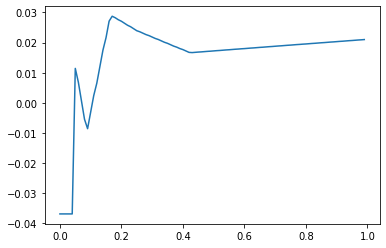

In [6]:
# Calculate the drift function
# response_forwards = {indx: f[indx] for indx in all_maturities}
# LOOKUP_forwards = np.array(list(response_forwards.values()))
# LOOKUP_time =  expiry_times.numpy().reshape(-1)

LOOKUP_forwards = np.array(list(response_forwards.values()))
LOOKUP_time =  expiry_times.numpy().reshape(-1)

def custom_discount_factor_fn_helper(t):
  ''' calculates piecewise r'''
  # Check if t is out of range 
  if t > LOOKUP_time[-1]:
    r = np.log(LOOKUP_forwards[-1]/LOOKUP_forwards[-2])/(LOOKUP_time[-1] - LOOKUP_time[-2])
    
  # Check if t is out of range 
  elif t < LOOKUP_time[0]:
    r = np.log(LOOKUP_forwards[0]/SPOT_REF)/LOOKUP_time[0]
  # in range
  else:
    time_diff = t - LOOKUP_time
    # check if t matches a value exactly
    if (time_diff == 0).sum() == 1:
      indx = np.where(time_diff == 0)[0][0]
      r = (np.log(LOOKUP_forwards[indx]/LOOKUP_forwards[indx-1])/(LOOKUP_time[indx]-LOOKUP_time[indx-1]))
    else:
      x = LOOKUP_forwards[np.where(time_diff > 0, time_diff, np.inf).argmin()]
      x_t = LOOKUP_time[np.where(time_diff > 0, time_diff, np.inf).argmin()]
      y = LOOKUP_forwards[np.where(time_diff < 0, time_diff, -np.inf).argmax()]
      y_t = LOOKUP_time[np.where(time_diff < 0, time_diff, -np.inf).argmax()]
      r = np.log(y/x) / (y_t - x_t)
  return r

def precompute_r():
  ''' pre-computes r as a hashmap for tensor compatibility ->  
  '''
  x = np.array(list(range(15000)))
  Y_R = []
  for i in x:
    Y_R.append(custom_discount_factor_fn_helper(i/10000))
  X_R = tf.convert_to_tensor(x)
  Y_R = tf.convert_to_tensor(np.array(Y_R))
  Y_lookup = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(X_R, Y_R), default_value=-1)
  return Y_lookup

Y_LOOKUP = precompute_r()

def custom_discount_factor_fn(t):
  ''' custom discount factor fn using piecewise r as a function of t'''
  indx = tf.cast(t*10000, tf.int32)
  rates = Y_LOOKUP.lookup(indx)
  return tf.math.exp(-rates*t)

a = tf.constant((np.array(list(range(100)))/100).reshape(-1,1))
b = Y_LOOKUP.lookup(tf.cast(a*10000, tf.int32)).numpy()

plt.plot(a,b)
plt.show()

### Optional: Check that the implied volsurface looks legit -> fast

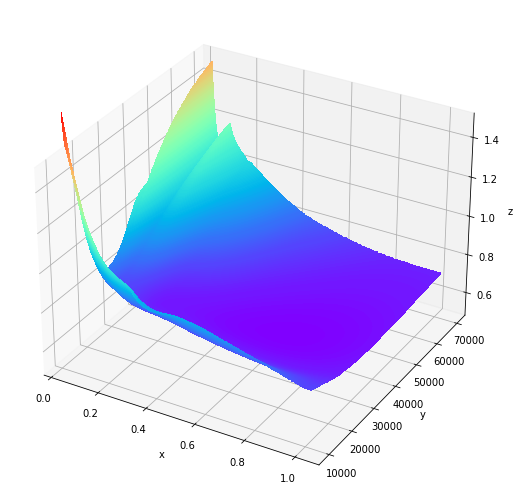

In [7]:
# Graph Volsurface
import plotly.graph_objects as go
t = expiry_times.numpy().reshape(-1)
zz = input_vols.reshape((-1, len(S)))
xx, yy = np.meshgrid(S, t)

plt.figure(figsize=(10,9))
ax = plt.axes(projection='3d')
# print(len(S), t.shape, xx.shape, yy.shape, zz.shape)
ax.contourf3D(yy, xx, zz, 300, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(0.5, 1.5)
plt.show()

### Optional: Visualise local volsurface -> takes a while

In [8]:
# Check the function
volsurface.volatility(strike=[[SPOT_REF]], expiry_times=[[1]])

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.71395521]])>

In [9]:
#from tf_quant_finance.experimental.local_volatility import local_volatility_model

dupire_local_volatility = _dupire_local_volatility_iv

# Query specific times and spots 
# if times.shape > spots.shape => ERROR (?)
k = 20
times = tf.convert_to_tensor([i/k for i in range(k)], dtype=tf.float64)
spots = tf.reshape(tf.constant([20000 + 1000*i for i in range(21)], dtype=tf.float64), [-1, 1])

# Should remain constant
initial_spot = tf.constant([[SPOT_REF]], dtype=tf.float64)
discount_factor_fn = lambda t: tf.math.exp(-0 * t)
dividend_yield = [0.]

# Looks like all the spot/strike inputs in non-log terms
# -> Double checks 
# Query function

xa = np.array([i/k for i in range(k)])
ya = np.array([20000 + 1000*i for i in range(21)])
lvs = np.empty((xa.shape[0], ya.shape[0]))

for xxx, xai in enumerate(xa):
  for yyy, yai in enumerate(ya):
    times = tf.convert_to_tensor([xai], dtype=tf.float64)
    spots = tf.reshape(tf.constant([yai], dtype=tf.float64), [-1, 1])

    lvs[xxx, yyy] = dupire_local_volatility(times, 
                        spots, 
                        initial_spot, 
                        volsurface.volatility, 
                        custom_discount_factor_fn, 
                        dividend_yield)


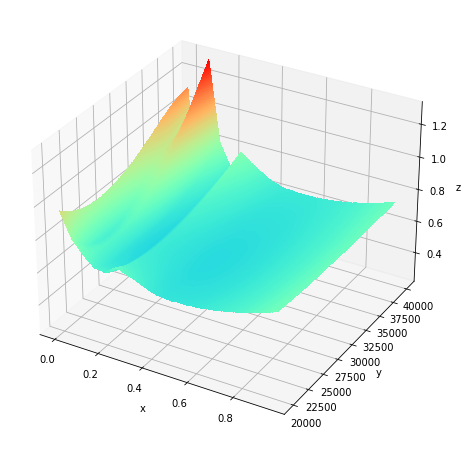

In [10]:
# Graph Volsurface
import plotly.graph_objects as go
xx, yy = np.meshgrid(ya, xa)

plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
# print(len(S), t.shape, xx.shape, yy.shape, zz.shape)
ax.contourf3D(yy, xx, lvs, 300, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_zlim(0.5, 1)
plt.show()

## 3. Test Vanillas 

In [66]:
# Set the dates you want to take paths snapshots
crit_dates = [
  #datetime.date(2022, 6, 24),
  datetime.date(2022, 7, 1),
  datetime.date(2022, 7, 29),
  datetime.date(2022, 8, 26),
  datetime.date(2022, 9, 30),
  datetime.date(2022, 12, 30),
  datetime.date(2023, 3, 31)
]

# strikes just for BS comparison reference
strikes = tf.constant([15000 + 1000*i for i in range(21)], dtype=tf.float64)

# For sampling 
# -> 50K throws and OOM Error for now
num_samples = 30000
num_timesteps = 500

# Keep as is - unless your risk profile changes
dtype = tf.float64 
# Converts dates to yearly fractions
critical_dates = tff.datetime.dates_from_datetimes(crit_dates).reshape((1,-1))
expiries = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=critical_dates, dtype=tf.float64)
expiries = expiries.numpy()[0].tolist() 
# Other stuff
dt = 1. / num_timesteps
rate = tf.constant(0, dtype=dtype)
spot = tf.constant(SPOT_REF, dtype=dtype)


## 3.5. Get BS closed form solution equivalent prices + vols

In [67]:
# Get current Market Vol data -> Should be close enough to the original volsurface
# TODO make sure it's exactly the same through check 
bs_market_ivs = np.empty((strikes.shape[0], len(crit_dates)))
forwards = np.empty(len(crit_dates))

volsurface_refs = pd.DataFrame(response_ivs)

for a, m in enumerate(crit_dates):
  m = m.strftime('%d%b%y').upper() 
  # Get forward
  forwards[a] = response_forwards[m]
  # OUTDATED:
  # forwards[a] = client.get_endpoint('fittedPara/forward_price', {"symbols": "BTC", "maturities": m, "strikes": 30000})[0]
  for b, k in enumerate(strikes):
    k = k.numpy()
    # Get vols from surface to match above
    bs_market_ivs[b, a] = volsurface_refs.loc[str(k), m]
    # OUTDATED
    # bs_market_ivs[b, a] = client.get_endpoint('fittedVol/single', {"symbols": "BTC", "maturities": m, "strikes": k})["volBTCModel"]

Option prices using market data and choice of forward in terms of $e^{rt}$

In [68]:
# Calculate call option prices using market data
USE_RISK_FREE_RATE = False
RISK_FREE_RATE = 0.0206

bs_market_prices = np.empty((strikes.shape[0], len(crit_dates)))

if USE_RISK_FREE_RATE:
  for a, _ in enumerate(crit_dates):
    v = bs_market_ivs[:, a]
    bs_market_prices[:,a] = option_price(
                              volatilities=v,
                              strikes=strikes.numpy()/ (SPOT_REF * np.exp(RISK_FREE_RATE * expiries[a])) ,
                              expiries=np.array([expiries[a]]*len(strikes)),
                              forwards=1,
                              discount_factors=1,
                              is_call_options=np.array([strike > 30000 for strike in strikes])
                              ).numpy() * (SPOT_REF * np.exp(RISK_FREE_RATE * expiries[a])) 
else:
  for a, _ in enumerate(crit_dates):
    v = bs_market_ivs[:, a]
    bs_market_prices[:,a] = option_price(
                              volatilities=v,
                              strikes=strikes.numpy()/ forwards[a],
                              expiries=np.array([expiries[a]]*len(strikes)),
                              forwards=1,
                              discount_factors=1,
                              is_call_options=np.array([strike < 22000 for strike in strikes])
                              ).numpy() * forwards[a]
    
  
#print(SPOT_REF * np.exp(RISK_FREE_RATE * np.array(expiries)))
print(forwards)
print(expiries)

[21834.23769991 21836.37738433 21874.04426572 21925.33907055
 22025.53830246 22127.5165983 ]
[0.043835616438356165, 0.12054794520547946, 0.19726027397260273, 0.29315068493150687, 0.5424657534246575, 0.7917808219178082]


## 4. Run MC for Vanilla Calls

In [69]:
# Volmodel Implementation 

def set_up_pricer(expiries):
    """Set up European option pricing function under Black-Scholes model.
    """
    def price_eu_options_local_vol(strikes, spot):
        '''
        Use LocalVolatilityModel class to set up the Ito process:
          - passes the volsurface and spot etc using dupire from iv's 
          - then calls __init__() for initialise localvolmodel
        '''
        # HAS to be spot and not Log spot -> 
        # converted in _dupire_local_volatility_iv()
        process = LocalVolatilityModel.from_volatility_surface(dim = 1,
                                                spot = spot,
                                                implied_volatility_surface = volsurface,
                                                discount_factor_fn = custom_discount_factor_fn, #lambda t: tf.math.exp(-RISK_FREE_RATE* t),
                                                dtype=tf.float64)

        # HAS to be spot -> 
        # is converted to log spot in sample_paths()
        paths = process.sample_paths(
            expiries, 
            num_samples=num_samples,
            initial_state=spot, 
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)

        return paths
      
    return price_eu_options_local_vol

price_eu_options_local_vol = tf.function(set_up_pricer(expiries))

p_coll = []
for i in range(7): 
  p = price_eu_options_local_vol(strikes, spot)
  p_coll.append(p)

### Loop through only one maturity to compute the error

In [71]:
paths_coll = np.array([])
for p in p_coll:
  prices = p.numpy().copy()
  paths = prices.reshape(30000, -1)
  paths = paths[:, -2]
  paths_coll = np.concatenate((paths_coll, paths))

In [76]:
print(paths_coll.shape)
tf.nn.relu(15000- paths_coll).numpy().std()/np.sqrt(paths_coll.shape[0])/SPOT_REF, tf.nn.relu(15000- paths_coll).numpy().mean()/SPOT_REF

(210000,)


(0.00031381953806640167, 0.07295088711871803)

### Collect all the simulated paths

In [70]:
coll = None
for k, p in enumerate(p_coll):
  if k == 0:
    coll = p.numpy().reshape(30000, -1)
  else:
    coll = np.concatenate((coll,  p.numpy().reshape(30000, -1)))
  print(coll.shape)

(30000, 6)
(60000, 6)
(90000, 6)
(120000, 6)
(150000, 6)
(180000, 6)
(210000, 6)


#### Compute all the different call/put prices from MC

In [73]:
# prices = p.numpy().copy()
# paths = prices.reshape(30000, -1)
paths = coll

mc_market_prices = np.empty((strikes.shape[0], len(crit_dates)))
for a, _ in enumerate(crit_dates):
  ps = paths[:, a]
  for j, s in enumerate(strikes):
    if s < 22000:
      diff = ps - s
    else:
      diff = s - ps
    mc_market_prices[j, a] = tf.reduce_mean(tf.nn.relu(diff))

#### Compute just the paths sum of MC

In [27]:
prices = p.numpy().copy()
paths = prices.reshape(30000, -1)

mc_market_prices = np.empty((strikes.shape[0], len(crit_dates)))
for a, _ in enumerate(crit_dates):
  ps = paths[:, a]
  for j, s in enumerate(strikes):
    if s < 30000:
      diff = ps 
    else:
      diff = ps
    mc_market_prices[j, a] = tf.reduce_mean(tf.nn.relu(diff))
    
mc_market_prices[1,:]

array([24753.42995226, 24767.4549635 , 24818.04178641, 24873.3476377 ,
       24954.08526823, 25084.46781771, 25238.94307275])

### Plot error across strikes -> percentage of spot

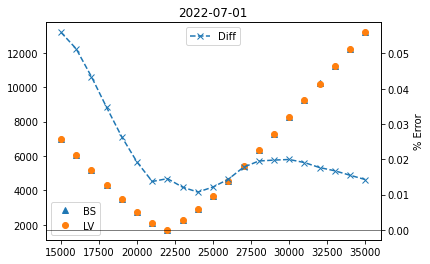

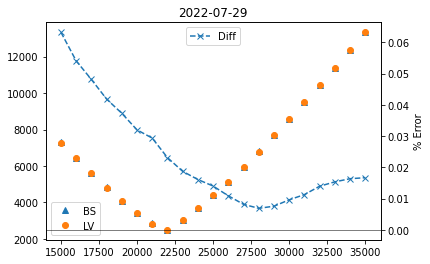

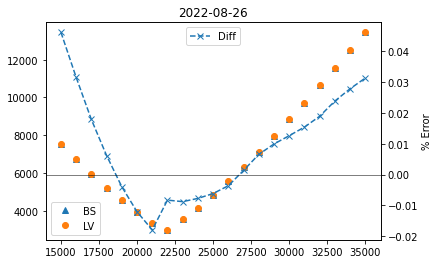

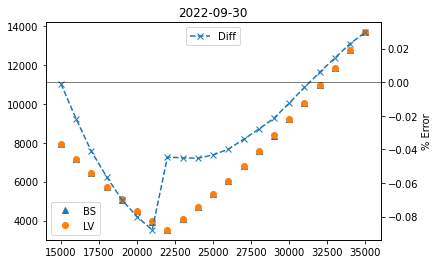

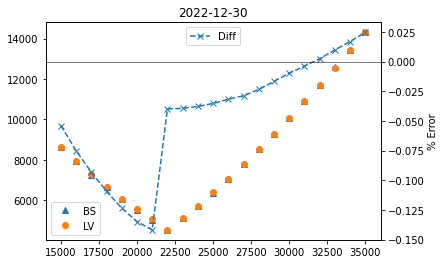

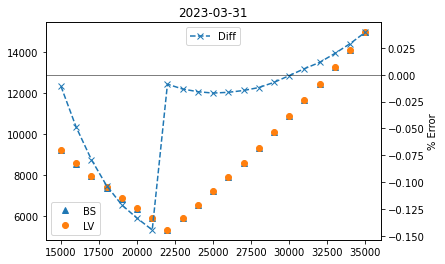

In [74]:
for a, d in enumerate(crit_dates):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  plt.title(d)
  ax1.plot(strikes, bs_market_prices[:, a], marker='^', linestyle='', label='BS')
  ax1.plot(strikes, mc_market_prices[:, a], marker='o', linestyle='', label='LV')
  ax2.plot(strikes, (bs_market_prices[:, a] - mc_market_prices[:, a]) / SPOT_REF * 100, marker='x', linestyle='--', label='Diff')
  ax2.axhline(0, color='k', linewidth=0.5)
  ax2.set_ylabel('% Error')
  ax1.legend(loc="lower left")
  ax2.legend(loc="upper center")
  plt.show()

### Plot error across maturities

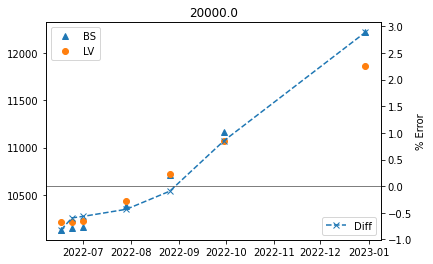

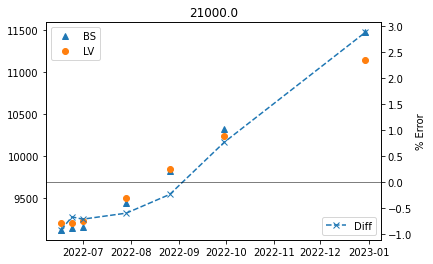

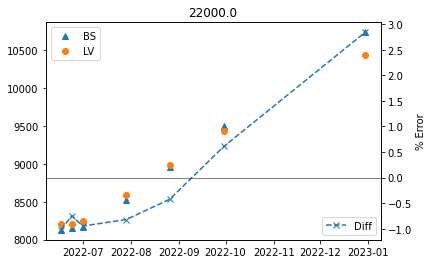

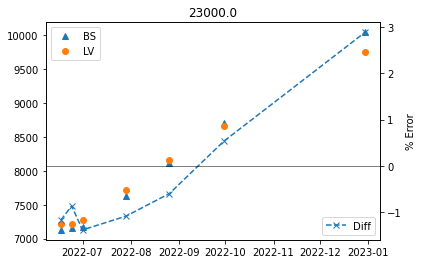

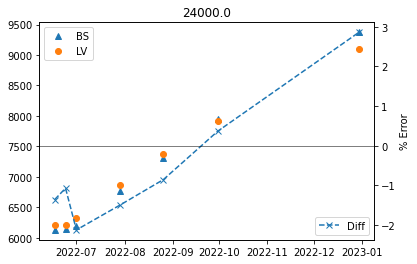

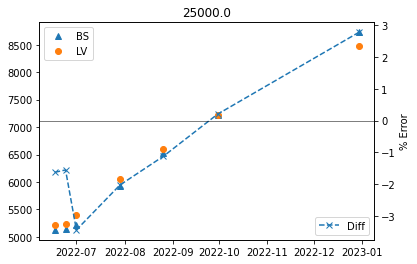

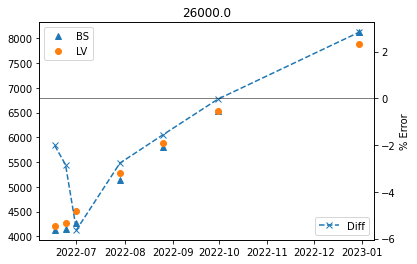

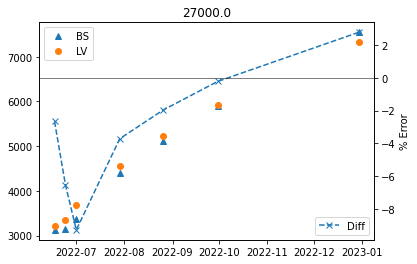

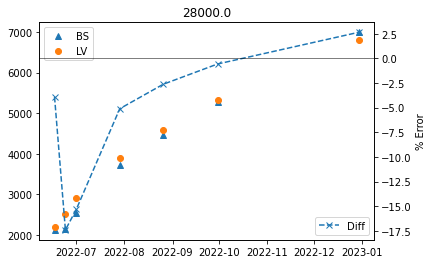

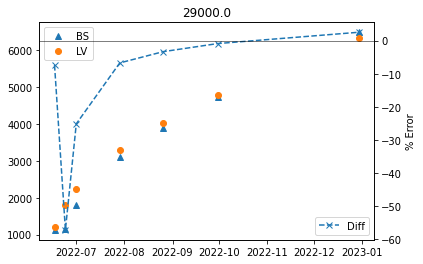

c:\Users\michael\Anaconda3\envs\googletf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
c:\Users\michael\Anaconda3\envs\googletf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


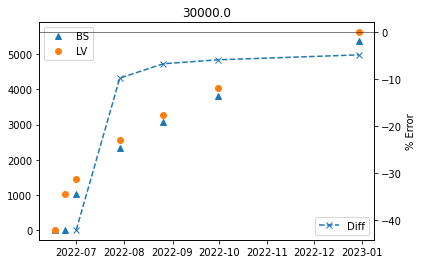

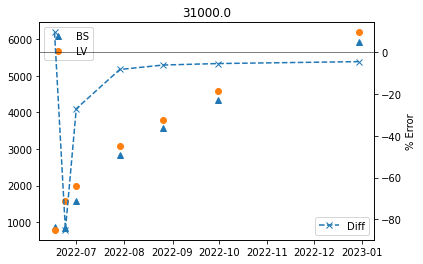

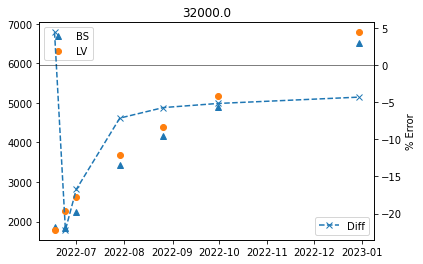

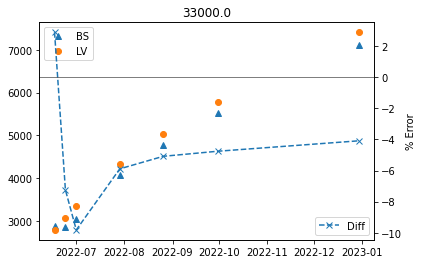

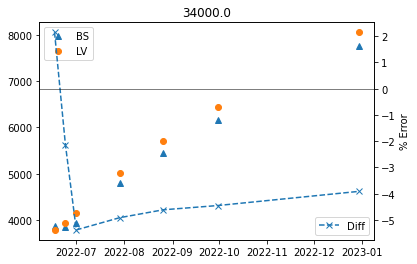

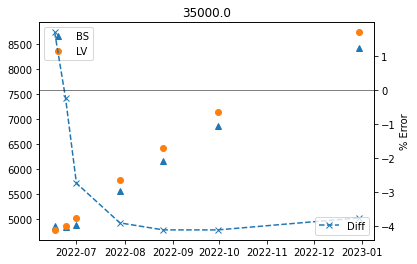

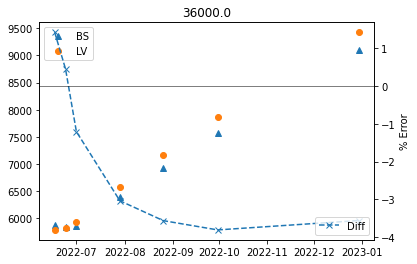

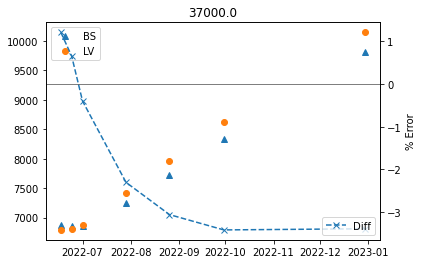

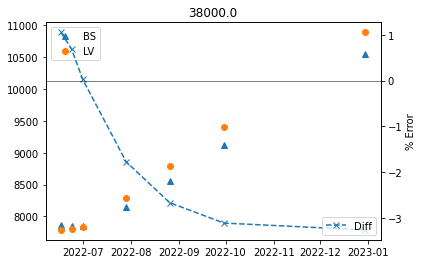

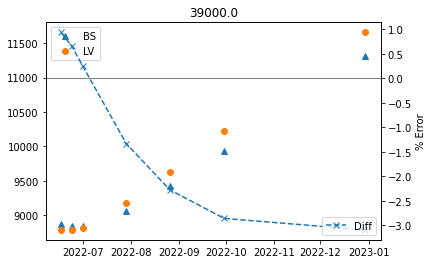

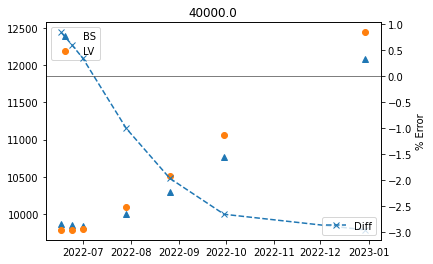

In [14]:
for b, k in enumerate(strikes):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  plt.title(k.numpy())
  ax1.plot(crit_dates, bs_market_prices[b, :], marker='^', linestyle='', label='BS')
  ax1.plot(crit_dates, mc_market_prices[b, :], marker='o', linestyle='', label='LV')
  ax2.plot(crit_dates, (bs_market_prices[b, :] - mc_market_prices[b, :])/ SPOT_REF *100, marker='x', linestyle='--', label='Diff')
  ax2.axhline(0, color='k', linewidth=0.5)
  ax2.set_ylabel('% Error')
  ax1.legend(loc="upper left")
  ax2.legend(loc="lower right")
  plt.show()

# NOT Cleaned up for now:

## Restart with a Volsurface from market data

In [28]:
# Construct tff native Datetensors
valuation_date = tff.datetime.dates_from_datetimes([DAY_REF])
dates = crit_dates

# SET expiries as a (1 x Maturities) tensor 
expiries = tff.datetime.dates_from_datetimes(dates).reshape((1,-1))

# SET strikes as (1 x Maturities x Strikes) tensor
strikes = np.array(strikes.numpy())
strikes = [expiries.shape[1]*[strikes.tolist()]]
strikes = tf.constant(strikes, dtype=tf.float64)
#strikes = tf.math.log(strikes)

input_vols = bs_market_ivs.reshape((1, strikes.shape[1], -1))

expiry_times = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=expiries, dtype=tf.float64)

def build_volatility_surface(val_date, expiry_times, expiries, strikes, iv, dtype):
  interpolator = tff.math.interpolation.interpolation_2d.Interpolation2D(expiry_times, strikes, iv, dtype=dtype)
  
  def _interpolator(t, x):
    x_transposed = tf.transpose(x)
    t = tf.broadcast_to(t, x_transposed.shape)
    return tf.transpose(interpolator.interpolate(t, x_transposed))

  return VolatilitySurface(val_date, expiries, strikes, iv, interpolator=_interpolator, dtype=dtype)

# Test that it returns the right surface
volsurface = build_volatility_surface(valuation_date, expiry_times, expiries, strikes, input_vols, dtype=tf.float64)


In [88]:
# Parameters Specification
SPOT_REF = 30173

crit_dates = [
  datetime.date(2022, 6, 10),
  datetime.date(2022, 6, 17),
  datetime.date(2022, 6, 24),
  datetime.date(2022, 7, 29),
  datetime.date(2022, 8, 26),
  datetime.date(2022, 9, 30),
  datetime.date(2022, 12, 30)
]
strikes = tf.constant([20000 + 1000*i for i in range(21)], dtype=tf.float64)

# For sampling 
num_samples = 50000
num_timesteps = 100

# Keep as is - unless your risk profile changes
dtype = tf.float64 
# Converts dates to yearly fractions
critical_dates = tff.datetime.dates_from_datetimes(crit_dates).reshape((1,-1))
expiries = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=critical_dates, dtype=tf.float64)
expiries = expiries.numpy()[0].tolist() #[1/12, 4/12, 6/12, 1] # This can be a rank 1 Tensor
# Other stuff
dt = 1. / num_timesteps
rate = tf.constant(0, dtype=dtype)
spot = tf.constant(SPOT_REF, dtype=dtype)


In [89]:
# Volmodel Implementation 
from tf_quant_finance.experimental.local_volatility import LocalVolatilityModel

def set_up_pricer(expiries):
    """Set up European option pricing function under Black-Scholes model.
    """
    def price_eu_options_local_vol(strikes, spot):
        '''
        Use LocalVolatilityModel class to set up the Ito process:
          - passes the volsurface and spot etc using dupire from iv's 
          - then calls __init__() for initialise localvolmodel
        '''
        # HAS to be spot and not Log spot -> 
        # converted in _dupire_local_volatility_iv()
        process = LocalVolatilityModel.from_volatility_surface(dim = 1,
                                                spot = spot,
                                                implied_volatility_surface = volsurface,
                                                discount_factor_fn = lambda t: tf.math.exp(0* t),
                                                dtype=tf.float64)

        # HAS to be spot -> 
        # is converted to log spot in sample_paths()
        paths = process.sample_paths(
            expiries, 
            num_samples=num_samples,
            initial_state=spot, 
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)

        # Computes the vanilla prices
        # prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
        #           * tf.reduce_mean(tf.nn.relu(strikes - paths), 0))

        return paths
      
    return price_eu_options_local_vol

price_eu_options_local_vol = tf.function(set_up_pricer(expiries))
p = price_eu_options_local_vol(strikes, spot)
p[1]

<tf.Tensor: shape=(7, 1), dtype=float64, numpy=
array([[30173.        ],
       [28978.10444552],
       [28978.10444552],
       [18630.93217142],
       [20516.8688442 ],
       [11780.51000451],
       [10150.48068125]])>

In [90]:
prices = p.numpy().copy()
paths = prices.reshape(50000, 7)

mc_market_prices2 = np.empty((strikes.shape[0], len(crit_dates)))
for a, _ in enumerate(crit_dates):
  ps = paths[:, a]
  for j, s in enumerate(strikes):
    if s < 30000:
      diff = ps - s
    else:
      diff = s - ps
    mc_market_prices2[j, a] = tf.reduce_mean(tf.nn.relu(diff))

c:\Users\michael\Anaconda3\envs\googletf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


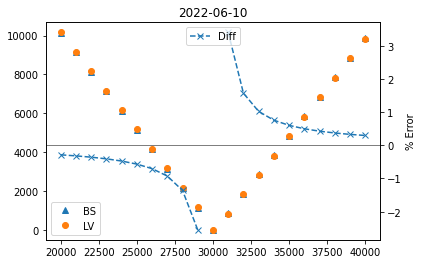

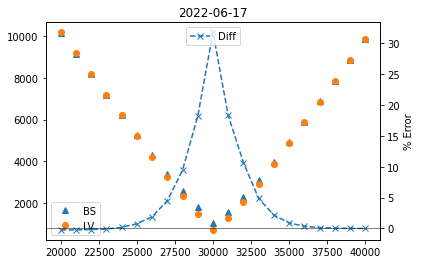

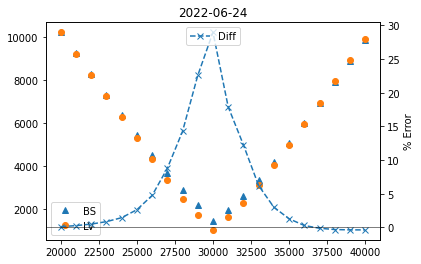

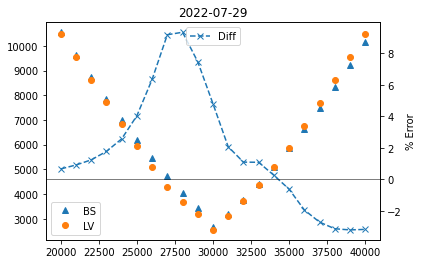

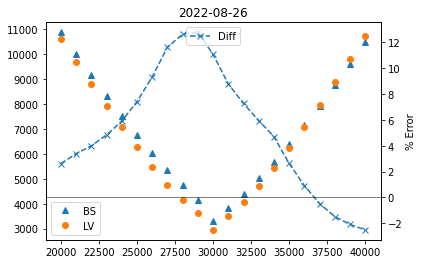

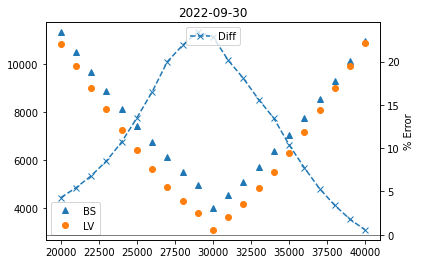

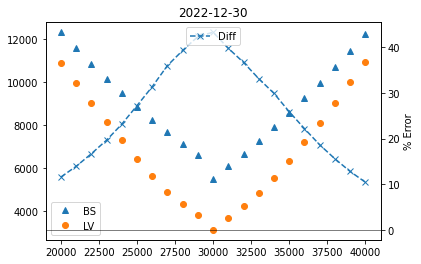

In [91]:
for a, d in enumerate(crit_dates):
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  plt.title(d)
  ax1.plot(strikes, bs_market_prices[:, a], marker='^', linestyle='', label='BS')
  ax1.plot(strikes, mc_market_prices2[:, a], marker='o', linestyle='', label='LV')
  ax2.plot(strikes, (bs_market_prices[:, a] - mc_market_prices2[:, a]) / bs_market_prices[:, a] * 100, marker='x', linestyle='--', label='Diff')
  ax2.axhline(0, color='k', linewidth=0.5)
  ax2.set_ylabel('% Error')
  ax1.legend(loc="lower left")
  ax2.legend(loc="upper center")
  plt.show()

## Run FCN Monte Carlo Simulation

In [10]:
# Parameters Specification
SPOT_REF = 30120
critical_dates = [
  datetime.date(2022, 7, 11),
  datetime.date(2022, 8, 9),
  datetime.date(2022, 9, 9),
  datetime.date(2022, 10, 10),
  datetime.date(2022, 11, 9),
  datetime.date(2022, 12, 9)
]
strikes = tf.constant([14896], dtype=tf.float64)

# For sampling 
num_samples = 30000
num_timesteps = 100

# Keep as is - unless your risk profile changes
dtype = tf.float64 
# Converts dates to yearly fractions
critical_dates = tff.datetime.dates_from_datetimes(critical_dates).reshape((1,-1))
expiries = tff.datetime.daycount_actual_365_fixed(start_date=valuation_date, end_date=critical_dates, dtype=tf.float64)
expiries = expiries.numpy()[0].tolist() #[1/12, 4/12, 6/12, 1] # This can be a rank 1 Tensor
# Other stuff
dt = 1. / num_timesteps
rate = tf.constant(0, dtype=dtype)
spot = tf.constant(SPOT_REF, dtype=dtype)


In [11]:
# Volmodel Implementation 
#from tf_quant_finance.experimental.local_volatility import LocalVolatilityModel

def set_up_pricer(expiries):
    """Set up European option pricing function under Black-Scholes model.
    """
    def price_eu_options_local_vol(strikes, spot):
        '''
        Use LocalVolatilityModel class to set up the Ito process:
          - passes the volsurface and spot etc using dupire from iv's 
          - then calls __init__() for initialise localvolmodel
        '''
        # HAS to be spot and not Log spot -> 
        # converted in _dupire_local_volatility_iv()
        process = LocalVolatilityModel.from_volatility_surface(dim = 1,
                                                spot = spot,
                                                implied_volatility_surface = volsurface,
                                                discount_factor_fn = lambda t: tf.math.exp(-0.029* t),
                                                dtype=tf.float64)
        
        # HAS to be spot -> 
        # is converted to log spot in sample_paths()
        paths = process.sample_paths(
            expiries, 
            num_samples=num_samples,
            initial_state=spot, 
            random_type=tff.math.random.RandomType.PSEUDO_ANTITHETIC,
            time_step=dt)

        # Computes the vanilla prices
        prices = (tf.exp(-tf.expand_dims(rate * expiries, axis=-1))
                  * tf.reduce_mean(tf.nn.relu(paths - strikes), 0))

        return paths, prices
      
    return price_eu_options_local_vol

price_eu_options_local_vol = tf.function(set_up_pricer(expiries))
p = price_eu_options_local_vol(strikes, spot)
p[1]

<tf.Tensor: shape=(6, 1), dtype=float64, numpy=
array([[15336.33252897],
       [15556.62290865],
       [15758.56326519],
       [15975.03113468],
       [16212.9212575 ],
       [16396.74864621]])>

### Check statistics whether the stochastic $S_t$ process was simulated correctly

In [8]:
# Gives you the min/max of the option prices across all simulations & expiries
# -> Can index for specific expiries across dimension 1
p[0].numpy().min(), p[0].numpy().max()

(2805.0649819047235, 168443.64461674076)

In [12]:
prices = p[0].numpy().copy()

### Analyse the price paths in numpy

In [14]:
# Coupon Payment
CONTRACT_REF = 29792
KO_LEVEL = CONTRACT_REF * 1

coupon = CONTRACT_REF * 18.5/12/100
print(f"Coupon payment: {18.5/12:.1f}% which is {coupon:.2f} USD")

# 3D -> 2D
paths = prices.reshape(30000, 6)
all_paths = prices.shape[0]

# Mask all Knockouts at all times
paths[paths > KO_LEVEL] = -1

# Mask paths subsequent of knockouts
mask = None
for j in range(paths.shape[1]):
  if mask is not None:
    paths[mask, j] = -1
  mask = (paths[:, j] == -1)

# Calculate Coupon payments in simulation
payoffs = []
probs = []
for j in range(paths.shape[1]):
  # for every observation date 
  paths_still_live = (paths[:, j] != -1).sum()
  payoffs.append(paths_still_live * coupon)
  probs.append(paths_still_live / all_paths)
  
payoffs = np.array(payoffs)
probs = np.array(probs)

# For the last expiry calculate the put payoff
im_puts = (paths[:, j] != -1) & (paths[:, j] < CONTRACT_REF//2)
put_payoff = sum(CONTRACT_REF//2 - paths[im_puts, j])

print('\n== For reference ==')
# Computes KO Probability at t1
t1 = paths[:, 0]
print(f"Knockout probability at t1: {t1[t1 == -1].shape[0]/all_paths * 100:.2f}%")

# Surviving paths at t6
t6 = paths[:, 5]
print(f"Total knockouts at t6: {t6[t6 == -1].shape[0]/all_paths * 100:.2f}%")

Coupon payment: 1.5% which is 459.29 USD

== For reference ==
Knockout probability at t1: 54.58%
Total knockouts at t6: 78.70%


#### Coupon payoffs at every observation date

In [15]:
print(f"Coupon payments: {np.array2string(payoffs, precision=2, floatmode='fixed')}") 
print(f"Probability of happening: {np.array2string(probs, precision=4, floatmode='fixed')}") 
print()

coupon_payment = sum(payoffs) / all_paths 

print(f"Total coupon payments to buyer EV: {coupon_payment:.2f} USD")

Coupon payments: [6258330.96 4728884.16 3965079.35 3472257.60 3153048.73 2934884.40]
Probability of happening: [0.4542 0.3432 0.2878 0.2520 0.2288 0.2130]

Total coupon payments to buyer EV: 817.08 USD


#### Put payoffs at expiry

In [16]:
put_payment = put_payoff/all_paths
print(f"Total put payment to seller EV: {put_payment:.2f} USD")


Total put payment to seller EV: 529.76 USD


#### Total Price

In [17]:
-2 * put_payment + coupon_payment

-242.44548492529577